In [32]:
#pip install -U nltk

In [33]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing

from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [34]:
df = pd.read_csv("3000tweet/3000tweet.csv", sep=';',encoding="utf8")
WPT = nltk.WordPunctTokenizer()

In [35]:
def preprocess_text(sen):
        
    # Remove punctuations and numbers
    sentence = re.sub('[^\w\s]', ' ', str(sen))
    
    #Single character removal
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    #Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stop_word_list = stopwords.words('turkish')
    
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)

    return single_doc.lower()


In [36]:
df['tweet'] = df['tweet'].apply(preprocess_text)

In [37]:
mes = []
for i in df['tweet']:
    mes.append(i.split())
print(mes[:2])

[['dun', 'turkcelle', 'tepkilerimizden', 'sonra', 'bugün', 'turkcell', 'twittera', 'sponsor', 'olmuş', 'ne', 'tesadüf', 'değil'], ['girmezmiyim', 'turkcell', 'kartim', 'bile', 'var', 'yarindan', 'itibaren', 'onu', 'takicam', 'twittersiz', 'denedim', 'sadece', 'gun', 'yapabildim']]


In [38]:
word2vec_model = Word2Vec(mes, size=500, window=3, min_count=1, workers=16)
print(word2vec_model)

Word2Vec(vocab=12038, size=500, alpha=0.025)


In [52]:
token = Tokenizer(12038)
token.fit_on_texts(df['tweet'])
text = token.texts_to_sequences(df['tweet'])
text = pad_sequences(text, 75)
print(text[:2])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  637  402 3241   29   34    1 3242
   954  161   64 1827   37]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 3243    1 3244   33    9 3245 1828  204 3246
  3247  775   45  174 3248]]


In [40]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['durum'])
y = to_categorical(y)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(np.array(text), y, test_size=0.2, stratify=y)

In [42]:
keras_model = Sequential()
keras_model.add(word2vec_model.wv.get_keras_embedding(True))
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(3))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
history=keras_model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_test, y_test))

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2400 samples, validate on 600 samples
Epoch 1/3
2400/2400 [==============================] - 16s 7ms/step - loss: 0.6248 - acc: 0.6693 - val_loss: 0.6101 - val_acc: 0.6706
Epoch 2/3
2400/2400 [==============================] - 15s 6ms/step - loss: 0.5186 - acc: 0.7400 - val_loss: 0.5786 - val_acc: 0.7028
Epoch 3/3
2400/2400 [==============================] - 15s 6ms/step - loss: 0.3532 - acc: 0.8029 - val_loss: 0.6544 - val_acc: 0.6867


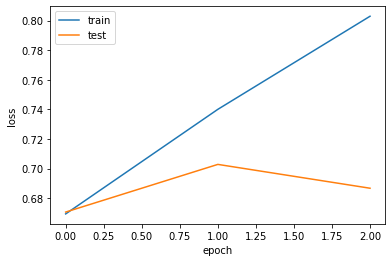

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
pred = keras_model.predict_classes(x_test)
pred

array([2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2,
       0, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1,
       0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 2, 0, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2,
       1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 1, 2,
       2, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2,
       2, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1,
       2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 1, 0, 2, 2,
       0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1,
       1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2,
       2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1,

In [50]:
accuracy = word2vec_model.accuracy(pred)


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.wv.evaluate_word_analogies() instead).
  """Entry point for launching an IPython kernel.


TypeError: don't know how to handle uri array([2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2,
       0, 2, 1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1,
       0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 2, 0, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2,
       1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 1, 2,
       2, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2,
       2, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1,
       2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 1, 0, 2, 2,
       0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1,
       1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2,
       2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1,
       0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 2, 1, 0, 1,
       1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 0,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       2, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1,
       2, 1, 1, 0, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2,
       0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2,
       2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1,
       0, 2, 2, 1, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2,
       2, 1, 2, 2, 2, 1, 2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 0, 2, 1, 2], dtype=int64)

In [45]:
rounded_labels=np.argmax(y_test, axis=1)

In [46]:
cm = confusion_matrix(rounded_labels,pred)
cm

array([[ 37,  20,  94],
       [ 18, 141,  99],
       [ 35,  55, 101]], dtype=int64)

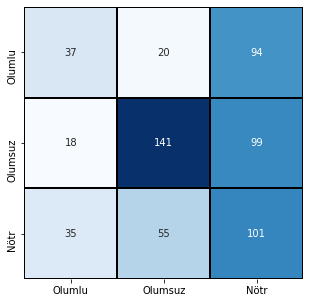

In [47]:
class_names = ['Olumlu','Olumsuz','Nötr']
cm = pd.DataFrame(cm , index = class_names , columns = class_names)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' ,cbar=False, linewidth = 1 , annot = True, fmt='' , xticklabels = class_names , yticklabels = class_names)